In [1]:
# Parameters 

application = 'Apple_and_Pears'
varname = 'RAIN_BC'
stat = 'sum'
num_quantiles = 3
target_type = 'anomalies'
step = 4
lag_sst = True
max_lag = 6
detrend_sst = False

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
%matplotlib inline

In [5]:
import sys 
import pathlib

In [6]:
import matplotlib.pyplot as plt 

In [7]:
import numpy as np 
import pandas as pd 
import xarray as xr
import cartopy.crs as ccrs
from scipy.signal import detrend

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
from sklearn.model_selection import LeaveOneOut, LeavePOut

### models 

In [10]:
from sklearn.linear_model import Ridge

### lagging function 

In [11]:
def make_lagged_df(df, max_lag=6, dropna=False): 
    df_lagged = pd.concat(
    [df.shift(i).add_suffix(f"_{i}") for i in range(max_lag)], axis=1
    )
    if dropna:
        df_lagged = df_lagged.dropna()
    return df_lagged

In [12]:
np.random.seed(42)

In [13]:
HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd()

### read the target variable 

In [14]:
ipath_target = pathlib.Path(HOME.joinpath(f"research/Smart_Ideas/outputs/targets/application_cases/{application}/SEASONAL/{varname}"))

In [15]:
target = pd.read_csv(ipath_target.joinpath(f"Seasonal_{varname}_{stat}_anomalies_and_Q{num_quantiles}_categories.csv"), index_col=0, parse_dates=True)

In [16]:
target = target.loc[:,[target_type]]

<AxesSubplot:xlabel='time'>

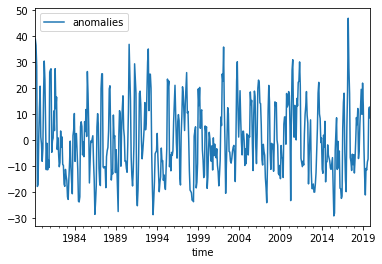

In [17]:
target.plot()

### keep only data post 1981 to enable direct comparison with GCM derived fields 

In [18]:
target = target.loc['1981':,:]

### reads the SSTs, seasonal anomalies, pre-computed 

In [19]:
ipath_sst = pathlib.Path(HOME.joinpath("/media/nicolasf/END19101/data/ERSST/processed"))

In [20]:
lfiles_sst = list(ipath_sst.glob("*.nc")) 

In [21]:
lfiles_sst.sort() 

In [22]:
lfiles_sst[0]

PosixPath('/media/nicolasf/END19101/data/ERSST/processed/ERSST_seasonal_anomalies_1979-03.nc')

In [23]:
lfiles_sst[-1]

PosixPath('/media/nicolasf/END19101/data/ERSST/processed/ERSST_seasonal_anomalies_2020-03.nc')

In [24]:
dset_sst = xr.open_mfdataset(lfiles_sst, concat_dim='time')

In [25]:
dset_sst

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 493)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1979-03-31 1979-04-30 ... 2020-03-31
    month    (time) int64 3 4 5 6 7 8 9 10 11 12 1 ... 5 6 7 8 9 10 11 12 1 2 3
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>

In [26]:
dset_sst = dset_sst.sel(time=slice('1981',None))

### domain selection 

In [27]:
domain_def = {}
domain_def['HB_seasonal'] = [120, 290, -60, 40]
domain_def['local'] = [150, 200, -50, -10]
domain_def['regional'] = [90, 300, -65, 50]
domain_def['ext_regional'] = [70, 300, -70, 60]
domain_def['global'] = [0, 360, -70, 70]
domain_def['tropics'] = [0, 360, -40, 40]

In [28]:
domain = 'HB_seasonal'

##### initial 

In [29]:
# dset_sst = dset_sst.sel(lat=slice(-60, 40), lon=slice(120, 290)) 

##### extended 

In [30]:
# dset_sst = dset_sst.sel(lat=slice(-70, 70)) 

##### local

In [31]:
dset_sst = dset_sst.sel(lat=slice(*domain_def[domain][2:]), lon=slice(*domain_def[domain][:2])) 

In [32]:
dset_sst

<xarray.Dataset>
Dimensions:  (lat: 51, lon: 86, time: 471)
Coordinates:
  * lat      (lat) float64 -60.0 -58.0 -56.0 -54.0 -52.0 ... 34.0 36.0 38.0 40.0
  * lon      (lon) float64 120.0 122.0 124.0 126.0 ... 284.0 286.0 288.0 290.0
  * time     (time) datetime64[ns] 1981-01-31 1981-02-28 ... 2020-03-31
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 5 6 7 8 9 10 11 12 1 2 3
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 51, 86), meta=np.ndarray>

### shift the time index in order to align the observed SST at time m - 4 with the observed rainfall at time 0, e.g. OND observed SST (predictor) --> aligned with FMA precip (target)

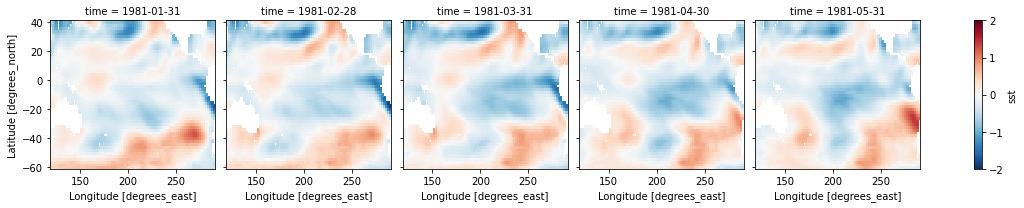

In [33]:
dset_sst.isel(time=slice(0, step + 1))['sst'].plot(x='lon', y='lat', col='time', vmin=-2, vmax=2, cmap='RdBu_r')

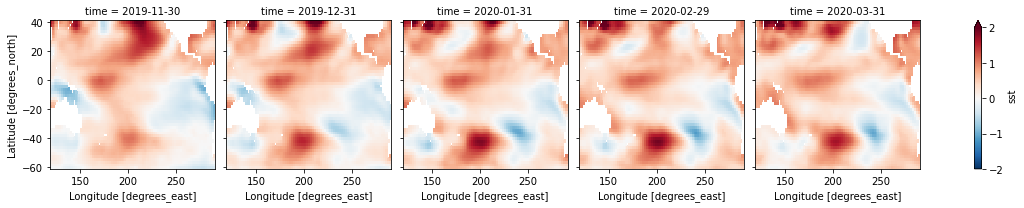

In [34]:
dset_sst.isel(time=slice(-(step + 1), None))['sst'].plot(x='lon', y='lat', col='time', vmin=-2, vmax=2, cmap='RdBu_r')

In [35]:
dset_sst_shift = dset_sst.copy()

In [36]:
dset_sst_shift = dset_sst.shift(time=step)

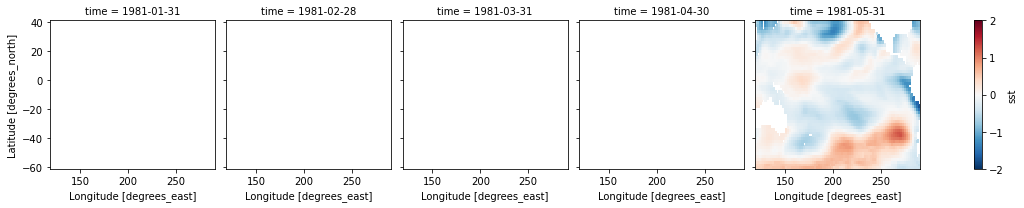

In [37]:
dset_sst_shift.isel(time=slice(0, step + 1 ))['sst'].plot(x='lon', y='lat', col='time', vmin=-2, vmax=2, cmap='RdBu_r')

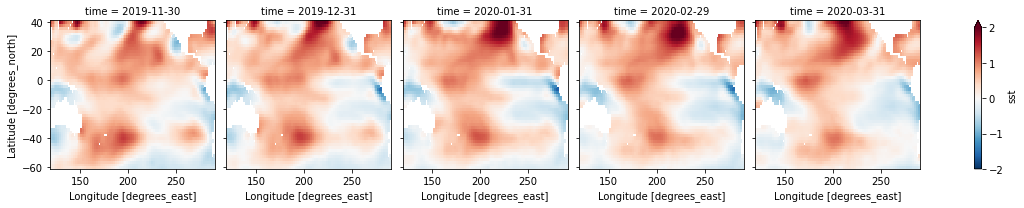

In [38]:
dset_sst_shift.isel(time=slice(-(step + 1), None))['sst'].plot(x='lon', y='lat', col='time', vmin=-2, vmax=2, cmap='RdBu_r')

### remove the first `step` seasons which are missing 

In [39]:
dset_sst_shift = dset_sst_shift.isel(time=slice(step, None))

In [40]:
dset_sst_shift = dset_sst_shift.stack(s=('lat','lon'))

In [41]:
dset_sst_shift

<xarray.Dataset>
Dimensions:  (s: 4386, time: 467)
Coordinates:
  * time     (time) datetime64[ns] 1981-05-31 1981-06-30 ... 2020-03-31
    month    (time) int64 5 6 7 8 9 10 11 12 1 2 3 ... 5 6 7 8 9 10 11 12 1 2 3
  * s        (s) MultiIndex
  - lat      (s) float64 -60.0 -60.0 -60.0 -60.0 -60.0 ... 40.0 40.0 40.0 40.0
  - lon      (s) float64 120.0 122.0 124.0 126.0 ... 284.0 286.0 288.0 290.0
Data variables:
    sst      (time, s) float32 dask.array<chunksize=(1, 4386), meta=np.ndarray>

### drop the land points 

In [42]:
dset_sst_shift = dset_sst_shift.dropna('s')

In [43]:
dset_sst_shift.load()

<xarray.Dataset>
Dimensions:  (s: 3981, time: 467)
Coordinates:
  * time     (time) datetime64[ns] 1981-05-31 1981-06-30 ... 2020-03-31
    month    (time) int64 5 6 7 8 9 10 11 12 1 2 3 ... 5 6 7 8 9 10 11 12 1 2 3
  * s        (s) MultiIndex
  - lat      (s) float64 -60.0 -60.0 -60.0 -60.0 -60.0 ... 40.0 40.0 40.0 40.0
  - lon      (s) float64 120.0 122.0 124.0 126.0 ... 284.0 286.0 288.0 290.0
Data variables:
    sst      (time, s) float32 0.42546868 0.45293152 ... 1.0377026 1.1396297

In [44]:
sst_data = dset_sst_shift['sst'].data

In [45]:
sst_data.shape

(467, 3981)

In [46]:
dset_sst_shift

<xarray.Dataset>
Dimensions:  (s: 3981, time: 467)
Coordinates:
  * time     (time) datetime64[ns] 1981-05-31 1981-06-30 ... 2020-03-31
    month    (time) int64 5 6 7 8 9 10 11 12 1 2 3 ... 5 6 7 8 9 10 11 12 1 2 3
  * s        (s) MultiIndex
  - lat      (s) float64 -60.0 -60.0 -60.0 -60.0 -60.0 ... 40.0 40.0 40.0 40.0
  - lon      (s) float64 120.0 122.0 124.0 126.0 ... 284.0 286.0 288.0 290.0
Data variables:
    sst      (time, s) float32 0.42546868 0.45293152 ... 1.0377026 1.1396297

In [47]:
df_sst = pd.DataFrame(np.array(sst_data), index=dset_sst_shift.time.to_index())

In [48]:
if detrend_sst: 
    df_sst = df_sst.apply(detrend)

### lag ? 

In [49]:
if lag_sst: 
    df_sst = make_lagged_df(df_sst, dropna=True)

### make sure the target is at the right frequency 

In [50]:
target.index.freq = 'M'

In [51]:
target.index

DatetimeIndex(['1981-01-31', '1981-02-28', '1981-03-31', '1981-04-30',
               '1981-05-31', '1981-06-30', '1981-07-31', '1981-08-31',
               '1981-09-30', '1981-10-31',
               ...
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', name='time', length=468, freq='M')

### put together the features and the target 

In [52]:
df = pd.concat([df_sst, target], axis=1)

In [53]:
df.head(10)

,0_0,1_0,2_0,3_0,4_0,5_0,6_0,7_0,8_0,9_0,...,3972_5,3973_5,3974_5,3975_5,3976_5,3977_5,3978_5,3979_5,3980_5,anomalies
time,,,,,,,,,,,,,,,,,,,,,
1981-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.024478
1981-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.478518
1981-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.688006
1981-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.288448
1981-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.845328
1981-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.242297
1981-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.672667
1981-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.517721
1981-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.097795


In [54]:
df.tail(10)

,0_0,1_0,2_0,3_0,4_0,5_0,6_0,7_0,8_0,9_0,...,3972_5,3973_5,3974_5,3975_5,3976_5,3977_5,3978_5,3979_5,3980_5,anomalies
time,,,,,,,,,,,,,,,,,,,,,
2019-06-30,0.070164,0.083603,0.117419,0.157951,0.191700,0.197906,0.155441,0.096012,0.051756,0.017702,...,-0.075033,0.040132,0.237953,0.482373,0.682913,1.927963,1.883726,1.889358,1.926851,-10.905409
2019-07-31,0.040030,0.066997,0.116070,0.170550,0.219374,0.235022,0.197653,0.144426,0.107945,0.089498,...,0.001611,0.092978,0.270830,0.501258,0.688697,1.821669,1.756496,1.733206,1.769820,-11.516973
2019-08-31,0.030762,0.075377,0.149820,0.236188,0.318111,0.362172,0.347685,0.314055,0.298182,0.303365,...,0.454943,0.460003,0.517762,0.622570,0.728610,1.166771,1.109354,1.107220,1.186688,-8.370844
2019-09-30,0.067156,0.120798,0.210210,0.316811,0.419670,0.480790,0.478895,0.456438,0.453703,0.474300,...,0.690517,0.697859,0.734446,0.809492,0.911131,0.242399,0.187085,0.210900,0.311823,-7.299659
2019-10-31,0.110709,0.154740,0.231048,0.320290,0.404579,0.448335,0.431706,0.398140,0.387827,0.401469,...,0.788737,0.809831,0.831520,0.856492,0.909876,-0.416757,-0.363843,-0.213745,-0.062147,11.583566
2019-11-30,0.139806,0.165507,0.214928,0.269337,0.318541,0.333053,0.294879,0.246468,0.224448,0.224015,...,0.408832,0.502925,0.583108,0.620982,0.651341,-0.441316,-0.357568,-0.183989,-0.050078,12.746957
2019-12-31,0.083776,0.086358,0.105316,0.122533,0.134827,0.120190,0.063494,0.003334,-0.030574,-0.047638,...,0.060864,0.189895,0.300710,0.336517,0.342920,-0.286510,-0.150973,0.076421,0.231688,8.525577
2020-01-31,0.002080,-0.012536,-0.013261,-0.016449,-0.022417,-0.047975,-0.106200,-0.163115,-0.196911,-0.220356,...,-0.047256,0.069712,0.156612,0.161158,0.145299,0.191236,0.270978,0.402814,0.438559,NaN
2020-02-29,-0.013831,-0.035971,-0.043834,-0.052942,-0.064318,-0.092778,-0.150801,-0.206202,-0.240669,-0.267832,...,-0.037295,0.023826,0.097780,0.140150,0.174880,0.688077,0.732987,0.788707,0.717870,NaN


In [55]:
df = df.dropna(axis=0)

In [56]:
df.head(10)

,0_0,1_0,2_0,3_0,4_0,5_0,6_0,7_0,8_0,9_0,...,3972_5,3973_5,3974_5,3975_5,3976_5,3977_5,3978_5,3979_5,3980_5,anomalies
time,,,,,,,,,,,,,,,,,,,,,
1981-10-31,-0.037903,-0.027635,-0.031161,-0.024755,0.015680,0.087785,0.127075,0.171974,0.161534,0.170722,...,0.581705,0.607628,0.593648,0.533564,0.506667,-1.091065,-1.030591,-0.916759,-0.844929,16.586398
1981-11-30,-0.088452,-0.074617,-0.073852,-0.063112,-0.019391,0.057738,0.105502,0.159218,0.155047,0.168013,...,0.779552,0.809687,0.793489,0.721863,0.687952,-0.684669,-0.676358,-0.618497,-0.563119,-3.583509
1981-12-31,-0.083178,-0.057363,-0.040846,-0.009592,0.054980,0.151930,0.218309,0.288859,0.300203,0.328176,...,0.646268,0.762092,0.830067,0.803822,0.775673,-0.405702,-0.395685,-0.336811,-0.267130,0.912709
1982-01-31,0.140003,0.196787,0.249345,0.320706,0.423519,0.548384,0.627574,0.705634,0.733831,0.789905,...,0.355242,0.465580,0.521439,0.453079,0.374420,-0.331133,-0.338840,-0.296816,-0.207553,-5.372583
1982-02-28,0.262600,0.328359,0.388810,0.466164,0.572077,0.695237,0.766572,0.836100,0.861905,0.921259,...,0.224669,0.279029,0.283365,0.177876,0.083774,-0.697181,-0.630045,-0.490177,-0.306935,-10.242988
1982-03-31,0.397113,0.478726,0.554213,0.647134,0.768607,0.902476,0.976734,1.046278,1.076256,1.144380,...,0.306163,0.298554,0.232397,0.053464,-0.092365,-0.473529,-0.467027,-0.438691,-0.342524,-8.604134
1982-04-30,0.216691,0.273793,0.320109,0.379115,0.467836,0.576547,0.636686,0.695510,0.710319,0.759228,...,0.094461,0.039563,-0.002790,-0.086082,-0.132458,0.062863,0.015793,-0.075394,-0.131217,3.530441
1982-05-31,0.153906,0.202985,0.239385,0.287025,0.366875,0.470106,0.545400,0.582984,0.596663,0.642505,...,-0.060423,-0.152660,-0.199093,-0.255959,-0.263582,0.161477,0.089789,-0.041620,-0.166831,-2.608901
1982-06-30,0.025374,0.051499,0.059450,0.071694,0.115387,0.190548,0.265235,0.270329,0.268704,0.291168,...,-0.178926,-0.284670,-0.334534,-0.396503,-0.406862,-0.237851,-0.238869,-0.254386,-0.297120,1.238068


In [57]:
df.tail()

,0_0,1_0,2_0,3_0,4_0,5_0,6_0,7_0,8_0,9_0,...,3972_5,3973_5,3974_5,3975_5,3976_5,3977_5,3978_5,3979_5,3980_5,anomalies
time,,,,,,,,,,,,,,,,,,,,,
2019-08-31,0.030762,0.075377,0.149820,0.236188,0.318111,0.362172,0.347685,0.314055,0.298182,0.303365,...,0.454943,0.460003,0.517762,0.622570,0.728610,1.166771,1.109354,1.107220,1.186688,-8.370844
2019-09-30,0.067156,0.120798,0.210210,0.316811,0.419670,0.480790,0.478895,0.456438,0.453703,0.474300,...,0.690517,0.697859,0.734446,0.809492,0.911131,0.242399,0.187085,0.210900,0.311823,-7.299659
2019-10-31,0.110709,0.154740,0.231048,0.320290,0.404579,0.448335,0.431706,0.398140,0.387827,0.401469,...,0.788737,0.809831,0.831520,0.856492,0.909876,-0.416757,-0.363843,-0.213745,-0.062147,11.583566
2019-11-30,0.139806,0.165507,0.214928,0.269337,0.318541,0.333053,0.294879,0.246468,0.224448,0.224015,...,0.408832,0.502925,0.583108,0.620982,0.651341,-0.441316,-0.357568,-0.183989,-0.050078,12.746957
2019-12-31,0.083776,0.086358,0.105316,0.122533,0.134827,0.120190,0.063494,0.003334,-0.030574,-0.047638,...,0.060864,0.189895,0.300710,0.336517,0.342920,-0.286510,-0.150973,0.076421,0.231688,8.525577


### illustrates the effect of the lagging (for one grid point) 

In [58]:
df.filter(regex='^0_', axis=1)

,0_0,0_1,0_2,0_3,0_4,0_5
time,,,,,,
1981-10-31,-0.037903,-0.050947,0.052004,0.192077,0.370928,0.425469
1981-11-30,-0.088452,-0.037903,-0.050947,0.052004,0.192077,0.370928
1981-12-31,-0.083178,-0.088452,-0.037903,-0.050947,0.052004,0.192077
1982-01-31,0.140003,-0.083178,-0.088452,-0.037903,-0.050947,0.052004
1982-02-28,0.262600,0.140003,-0.083178,-0.088452,-0.037903,-0.050947
...,...,...,...,...,...,...
2019-08-31,0.030762,0.040030,0.070164,0.057744,0.054532,0.052865
2019-09-30,0.067156,0.030762,0.040030,0.070164,0.057744,0.054532
2019-10-31,0.110709,0.067156,0.030762,0.040030,0.070164,0.057744


In [59]:
solvers = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']

In [60]:
l_compared = []

for i in range(3):
    
    dfs = df.iloc[i:None:3,:]
    
    dfs = dfs.sample(frac=1.)
    
    loo = LeaveOneOut()
    
    y = []
    y_hat = []

    for train_index, test_index in loo.split(dfs):

        # initialise the Ridge Regressor 
        regressor = Ridge(alpha=0.5)

        # get the training and test set 
        X_train = dfs.iloc[train_index,:-1].values
        y_train = dfs.iloc[train_index,-1].values

        X_test = dfs.iloc[test_index,:-1].values
        y_test = dfs.iloc[test_index,-1].values

        y.append(y_test.ravel())

        # scale the features matrices

        # 1: initialise the StandardScaler
        scaler = StandardScaler()

        # 2: fit and transform the training set 
        X_train = scaler.fit_transform(X_train)

        # 3: transform the test set 
        X_test = scaler.transform(X_test)

        # 4: fit on the training set 
        regressor.fit(X_train, y_train)

        # 5: predict using the features on the test set 
        y_hat.append(regressor.predict(X_test).ravel())
        
    y = [x[0] for x in y]
    
    y_hat = [x[0] for x in y_hat]
    
    compare_df = pd.DataFrame(np.stack([y, y_hat], axis=-1), columns=['y','y_hat'], index=dfs.index) 
    
    l_compared.append(compare_df)

In [61]:
compare_df = pd.concat(l_compared, axis=0)


In [62]:
compare_df.sort_index(inplace=True)

### the overall correlation coefficient is pretty low 

In [63]:
compare_df.corr()

,y,y_hat
y,1.000000,0.262191
y_hat,0.262191,1.000000


### but that masks some strong seasonal dependency 

In [64]:
corr_per_seas = compare_df.groupby(compare_df.index.month).corr().iloc[::2,[1]]

In [65]:
corr_per_seas.columns = ['R']

In [66]:
corr_per_seas = corr_per_seas.droplevel(1)

In [67]:
from calendar import month_abbr

In [68]:
corr_per_seas.index = month_abbr[1:]

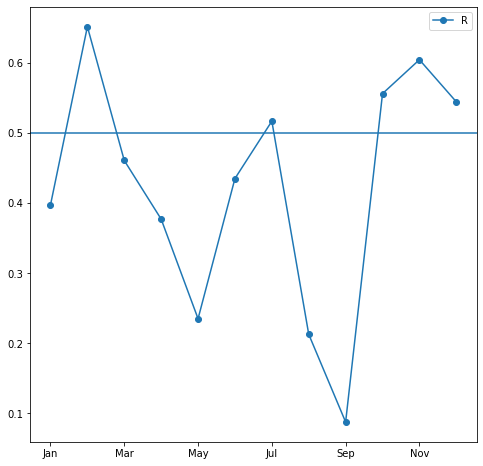

In [69]:
f, ax = plt.subplots(figsize=(8,8))
corr_per_seas.plot(marker='o', ax=ax)
ax.axhline(0.5)

In [70]:
ess = compare_df.loc[compare_df.index.month.isin([10])]

<AxesSubplot:xlabel='time'>

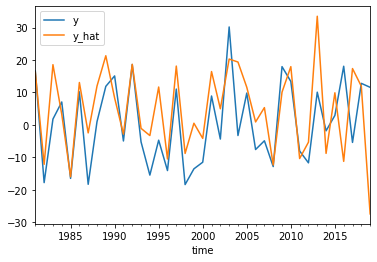

In [71]:
ess.plot()

<AxesSubplot:xlabel='y', ylabel='y_hat'>

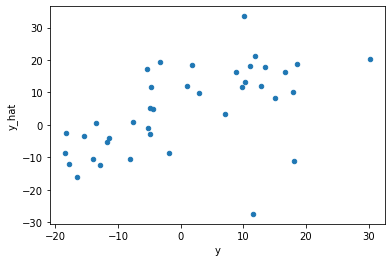

In [72]:
ess.plot.scatter(x='y',y='y_hat')